In [2]:
from sklearn.datasets import fetch_20newsgroups
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re
from emot.emo_unicode import UNICODE_EMO, EMOTICONS
import warnings
warnings.filterwarnings('ignore') 

%matplotlib inline

import spacy
import en_core_web_sm
import string

from wordcloud import WordCloud

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from gensim import corpora, models

from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
dataset, target = fetch_20newsgroups( shuffle=True, random_state=123, remove=('headers', 'footers', 'quotes'), return_X_y=True )

In [4]:
topics=['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [5]:
df = pd.DataFrame(list(zip(dataset, target)),
               columns =['text', 'topic'])

In [6]:
df.text.apply(lambda x: len(x.split(" "))).median()

84.0

In [7]:
unique, counts = np.unique(df.topic.values, return_counts=True)

In [8]:
counts

array([480, 584, 591, 590, 578, 593, 585, 594, 598, 597, 600, 595, 591,
       594, 593, 599, 546, 564, 465, 377], dtype=int64)

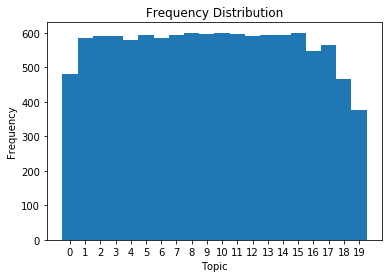

In [9]:
plt.bar(unique, counts, 1)
plt.title('Frequency Distribution')
plt.xlabel('Topic')
plt.ylabel('Frequency')
plt.xticks(range(0,20))
plt.show()

In [10]:
df=df[df.text.str.strip()!=""]

In [11]:
df.topic.unique()

array([ 4, 16, 13,  1, 19,  7,  2, 11, 12, 17, 10,  8, 15,  6, 18,  9,  0,
        3,  5, 14], dtype=int64)

In [12]:
df.shape

(11014, 2)

In [13]:
nlp = en_core_web_sm.load()

def expand_contractions(text):
    contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                 "can't": "cannot","can't've": "cannot have",
                 "'cause": "because","could've": "could have","couldn't": "could not",
                 "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                 "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                 "hasn't": "has not","haven't": "have not","he'd": "he would",
                 "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                 "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                 "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                 "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                 "it'd": "it would","it'd've": "it would have","it'll": "it will",
                 "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                 "mayn't": "may not","might've": "might have","mightn't": "might not", 
                 "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                 "mustn't've": "must not have", "needn't": "need not",
                 "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                 "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                 "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                 "she'll": "she will", "she'll've": "she will have","should've": "should have",
                 "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                 "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                 "there'd've": "there would have", "they'd": "they would",
                 "they'd've": "they would have","they'll": "they will",
                 "they'll've": "they will have", "they're": "they are","they've": "they have",
                 "to've": "to have","wasn't": "was not","we'd": "we would",
                 "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                 "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                 "what'll've": "what will have","what're": "what are", "what've": "what have",
                 "when've": "when have","where'd": "where did", "where've": "where have",
                 "who'll": "who will","who'll've": "who will have","who've": "who have",
                 "why've": "why have","will've": "will have","won't": "will not",
                 "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                 "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                 "y'all'd've": "you all would have","y'all're": "you all are",
                 "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                 "you'll": "you will","you'll've": "you will have", "you're": "you are",
                 "you've": "you have"}

    # Regular expression for finding contractions
    contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text) 
def lemmatization(input_txt):
    doc = nlp(input_txt)
    spacy_words = [t.lemma_ for t in doc if ((t.text in nlp.vocab) and (not t.is_stop) and (t.pos_ in ["ADJ","NOUN","VERB","PROPN"])  )]
    sentence=" ".join(spacy_words)
    return sentence

    
import re

def preprocess(text):
    text=expand_contractions(text)
    text=str(text).lower()    
    text=text.replace("\n"," ")
    text=text.replace("\t"," ")    
    text=re.sub(r'\S*\d+\S*', '', text)
    text=re.sub("\S*@\S*\s?",'',text)
    text=re.sub(r'[0-9]', '', text)    
    text=re.sub('[^A-Za-z ]+', ' ', text)
    text=re.sub(' +',' ',text)
    text=re.sub(r"http\S+", "", text)
    text=lemmatization(text)
    text=' '.join([w for w in text.split() if len(w)>3])
    return text

df.text=df.text.apply(lambda x: preprocess(x))

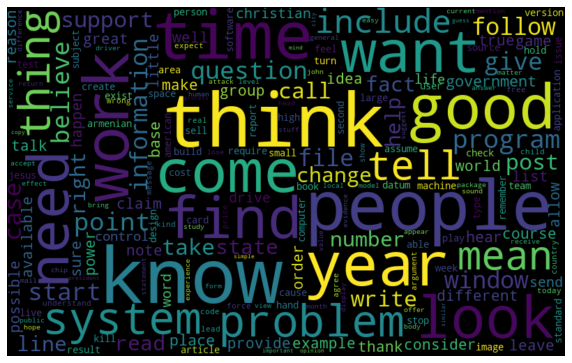

In [14]:
tokens=[x.split() for x in df.text.values]
all_words = [item for sublist in tokens for item in sublist]

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(' '.join(all_words))

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [15]:
df.head()

,text,topic
0,quick query powerbook gurus spearman post alte...,4
1,article irrational fool rkba plenty people sup...,16
2,steve look construvtive word constructive wast...,13
3,routine change color attribute adapter work mo...,1
4,wonder kekule dream influence aromatic solvent...,13


In [17]:
def find_keywords(docs):
    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform(docs)
    keywords=[]
    for vector in vectors:
        names = vectorizer.get_feature_names()
        data = vector.T.todense().tolist()
        tmp = pd.DataFrame(data, index=names,columns=["tfidf"])
        tmp=tmp.sort_values(by=["tfidf"],ascending=False)
        words=tmp.index[:15].tolist()
        keywords.append(words)
    return keywords

topics_docs=df.groupby("topic",as_index=False)
topics_docs_array=[]
for topic, docs in topics_docs:
    clean_docs_array=[]
    for i, row in docs.iterrows():
        text = row['text']
        clean_docs_array.append(text)
    topics_docs_array.append(" ".join(clean_docs_array))
topics_keywords=find_keywords(topics_docs_array)

In [18]:
df_topics=pd.DataFrame({"topic":topics,"keywords":topics_keywords})

In [19]:
df_topics

,topic,keywords
0,alt.atheism,"[atheism, atheist, people, religion, think, is..."
1,comp.graphics,"[image, jpeg, file, graphic, format, program, ..."
2,comp.os.ms-windows.misc,"[window, file, problem, font, driver, windows,..."
3,comp.sys.ibm.pc.hardware,"[drive, scsi, controller, card, disk, system, ..."
4,comp.sys.mac.hardware,"[drive, apple, problem, scsi, quadra, nubus, k..."
5,comp.windows.x,"[widget, window, motif, file, program, entry, ..."
6,misc.forsale,"[sale, good, offer, include, shipping, sell, p..."
7,rec.autos,"[good, engine, drive, brake, think, know, time..."
8,rec.motorcycles,"[bike, ride, motorcycle, helmet, know, think, ..."
9,rec.sport.baseball,"[year, team, game, good, player, baseball, thi..."


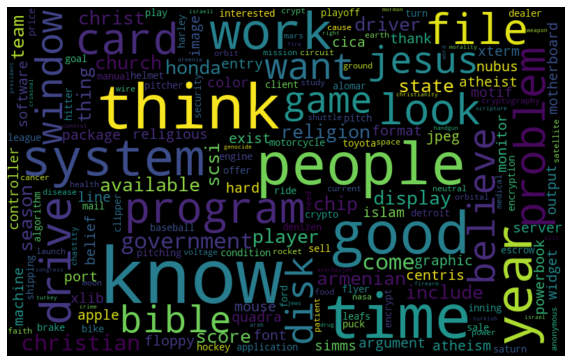

In [20]:
all_words = [item for sublist in df_topics.keywords.values for item in sublist]

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(' '.join(all_words))

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [287]:
df.text=df.text.apply(lambda x: x.split())

In [299]:
from sklearn.model_selection import train_test_split
X=df.loc[:,"text"]
y=df.loc[:,"topic"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [300]:
X_train

316      [motherboard, local, come, cirrus, logic, card...
7073     [opinion, thing, game, argument, defense, allo...
7682     [stuff, delete, stuff, delete, usenet, collect...
1798     [look, look, example, boss, seat, couple, regu...
3362     [team, mask, appear, average, helmet, cage, va...
                               ...                        
5208     [copy, disagree, good, book, look, graphic, fe...
10904    [post, john, want, tell, slight, difference, s...
3991     [discuss, liberty, permission, eric, interesti...
9903     [account, anti, armenian, human, right, azerba...
8000     [wonder, know, hard, drive, utility, work, har...
Name: text, Length: 8811, dtype: object

In [321]:
dictionary_LDA = corpora.Dictionary(X_train)
dictionary_LDA.filter_extremes(no_below=10, no_above=0.2)
corpus = [dictionary_LDA.doc2bow(doc) for doc in X_train]

In [322]:
lda_scores=[]
lda_models=[]
for i in range(6,21):    
    lda_model = models.LdaModel(corpus, num_topics=i,id2word=dictionary_LDA,alpha="auto",eta="auto",passes=10)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=X_train, dictionary=dictionary_LDA, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print("Number of topics: "+str(i))
    print('Coherence Score: ', coherence_lda,end="\n")
    lda_scores.append(coherence_lda)
    lda_models.append(lda_model)

Number of topics: 6
Coherence Score:  0.5170959048278645
Number of topics: 7
Coherence Score:  0.5678212333415187
Number of topics: 8
Coherence Score:  0.504299499895911
Number of topics: 9
Coherence Score:  0.5467017012505517
Number of topics: 10
Coherence Score:  0.5298123427071425
Number of topics: 11
Coherence Score:  0.5715843943504272
Number of topics: 12
Coherence Score:  0.5996078394691959
Number of topics: 13
Coherence Score:  0.5906859529760481
Number of topics: 14
Coherence Score:  0.5658490089201861
Number of topics: 15
Coherence Score:  0.5702127827596822
Number of topics: 16
Coherence Score:  0.5920884793257448
Number of topics: 17
Coherence Score:  0.5648043756444752
Number of topics: 18
Coherence Score:  0.5607476894125872
Number of topics: 19
Coherence Score:  0.607352059540113
Number of topics: 20
Coherence Score:  0.5631115457917456


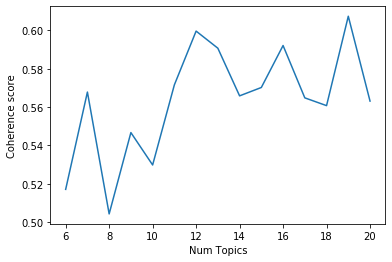

In [324]:
import matplotlib.pyplot as plt
x = range(6, 21)
plt.plot(x, lda_scores)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.show()

In [332]:
i=12-6
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_models[i], corpus, dictionary=lda_models[i].id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.040686  0.034009       1        1  15.791573
9      0.117841  0.103674       2        1  12.901145
11    -0.208674 -0.027738       3        1  11.732158
3      0.177182  0.002510       4        1   8.611199
5     -0.224958  0.086620       5        1   8.609836
8     -0.083793  0.132853       6        1   7.863285
6      0.042786 -0.132664       7        1   7.369866
10    -0.081395 -0.010627       8        1   6.843333
1      0.127448  0.240903       9        1   5.836043
2     -0.060821 -0.114570      10        1   4.857003
4     -0.075571 -0.164473      11        1   4.805308
0      0.229269 -0.150498      12        1   4.779251, topic_info=         Term         Freq        Total Category  logprob  loglift
159      file  2045.000000  2045.000000  Default  30.0000  30.0000
132     drive  1619.000000  1619.000000  Default  29.0000  29.0000
40       game   971.000000   971.000000  Default  28.0000  28.0000
171     space   897.000000   897.000000  Default  27.0000  27.0000
63       post  1273.000000  1273.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
1601     dead   141.795241   369.883001  Topic12  -4.9930   2.0821
17     people   288.525078  3305.454112  Topic12  -4.2826   0.6023
1060    world   159.513618   885.076987  Topic12  -4.8753   1.3273
440     woman   135.318052   511.006285  Topic12  -5.0398   1.7121
114   israeli   111.200851   253.461809  Topic12  -5.2360   2.2170

[819 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1470      1  0.993821  absolute
2812      7  0.097417  academic
2812      8  0.876750  academic
445       1  0.685101    accept
445       2  0.012830    accept
...     ...       ...       ...
316       8  0.004125      year
316       9  0.241979      year
316      10  0.115490      year
316      11  0.007791      year
316      12  0.050870      year

[2372 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 10, 12, 4, 6, 9, 7, 11, 2, 3, 5, 1])

In [329]:
i=12-6
lda_model = lda_models[i]
coherence_model_lda = CoherenceModel(model=lda_model, texts=X_test, dictionary=dictionary_LDA, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print("Number of topics: "+str(12))
print('Coherence Score: ', coherence_lda,end="\n")

Number of topics: 14
Coherence Score:  0.5081660504294551
